In [636]:
if not "__WDSET__" in globals():
    %cd -q ..
    __WDSET__ = True

In [637]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [638]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm.auto import tqdm


from wsfr_read.config import DATA_ROOT
from core.utils import Vector

In [652]:
len(X_test)

230

In [663]:
X_test

,ANOM_autocorr,ANOM_roll_max5,ANOM_roll_mean5,ANOM_roll_min5,INDEX_1,INDEX_10,INDEX_3,INDEX_4,INDEX_5,INDEX_6,...,soi_roll_mean5,stations_count,value_RAIN,value_SNOW WC,volume_ewm_mean7,volume_roll_max5,volume_roll_mean5,volume_roll_min5,volume_roll_std7,predictions
2635,0.695956,0.70,0.382,-0.57,-1.14,-0.07,-1.29,-0.92,-0.30,0.57,...,-4.400000e-01,20.0,NaN,NaN,114.086135,120.985,113.401000,104.155,8.537207,"[1972.8765801734148, 3272.255309113889, 3877.7..."
2691,0.785237,0.77,0.042,-1.50,-0.86,1.33,-2.62,-2.57,-1.84,-0.30,...,-6.200000e-01,20.0,NaN,NaN,102.487649,193.514,99.744000,31.659,83.928837,"[2148.8301814015067, 3374.1517438627625, 4044...."
2747,0.629387,1.36,0.034,-0.37,0.61,0.79,-0.14,-0.57,-0.81,-0.84,...,1.240000e+00,20.0,NaN,NaN,79.798000,113.999,78.955000,54.474,31.136620,"[2079.0247553895365, 3155.914297238661, 4038.0..."
2803,0.582152,-1.05,-1.338,-1.64,-0.08,0.25,-0.56,-0.50,-0.34,-0.07,...,1.980000e+00,21.0,NaN,NaN,77.107405,92.951,74.329000,49.002,22.728758,"[2050.1659634005714, 3292.6227406912644, 3988...."
2859,0.559966,0.37,0.218,-0.17,0.09,1.10,-1.23,-1.45,-1.28,-0.65,...,-8.881784e-17,21.0,NaN,NaN,105.051865,131.794,99.558667,52.103,41.969129,"[2075.151749492258, 3054.938841206934, 4119.40..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61563,0.563640,2.57,0.682,0.05,1.00,1.80,-0.81,-1.57,-1.86,-1.58,...,-7.000000e-01,5.0,NaN,NaN,28.911351,45.187,25.904667,14.532,16.788519,"[899.651044685099, 1089.4793094314855, 1553.42..."
61619,0.665225,-0.36,-0.612,-0.84,0.63,0.39,0.39,0.05,-0.28,-0.58,...,3.600000e-01,5.0,NaN,NaN,17.867351,20.736,17.277333,14.612,3.138133,"[822.6893471055782, 1173.3067308895604, 1504.9..."
61675,0.737993,0.76,0.416,0.09,1.69,1.96,0.21,-1.01,-1.82,-2.14,...,2.000000e-02,5.0,NaN,NaN,16.580486,18.728,16.087000,13.522,2.603832,"[788.6076130828538, 1184.1510383674486, 1525.8..."
61731,0.668188,-0.41,-0.804,-1.17,-0.22,-0.34,0.18,0.37,0.41,0.21,...,1.000000e+00,5.0,NaN,NaN,16.625784,17.347,16.432000,15.262,1.065634,"[796.0213538481643, 1151.3180246392178, 1702.5..."


In [666]:
X_test["predictions"] = np.transpose(y_pred_val, (1, 0))[:230].tolist()
X_test.query("site_id == 'hungry_horse_reservoir_inflow' & ANOM_roll_max5 == 0.70")["predictions"].iloc[0]

[1972.8765801734148, 3272.255309113889, 3877.7478682256947]

In [718]:
assets = {}

In [719]:
from core.solution import predict
from pathlib import Path

for idx, row in tqdm(df_submission.iterrows()):
    pass
    # result = predict(row.site_id, row.issue_date, assets=assets, src_dir=Path("."), data_dir=Path("./data"), preprocessed_dir=Path("."))

0it [00:00, ?it/s]

In [720]:
result = predict(row.site_id, row.issue_date, assets=assets, src_dir=Path("."), data_dir=Path("./data"), preprocessed_dir=Path("."))

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [721]:
# assets[(7, 22)]["test_features"]["predictions"]

In [722]:
result

[360.2056388821743, 381.4218442781598, 370.42609562081935]

In [601]:
from core.datasets import *
from core.data.feature import generate_timeseries_features, add_column_suffix

In [603]:
metadata = get_metadata().rename(columns={"area": "basins_area"})
df_train_monthly = pd.read_csv(DATA_ROOT / "train_monthly_naturalized_flow.csv")
df_test_monthly = pd.read_csv(DATA_ROOT / "test_monthly_naturalized_flow.csv")
df_train_targets = pd.read_csv(DATA_ROOT / "train.csv")
df_submission = pd.read_csv(DATA_ROOT / "submission_format.csv")

In [7]:
df_test_targets_v2 = df_test_monthly.merge(metadata, on="site_id").groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].between(df["season_start_month"], df["season_end_month"])]["volume"].sum()
).reset_index(name="volume")
df_train_targets_v2 = df_train_monthly.merge(metadata, on="site_id").groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].between(df["season_start_month"], df["season_end_month"])]["volume"].sum()
).reset_index(name="volume")

df_monthly = pd.concat((df_train_monthly, df_test_monthly))
df_targets = pd.concat((df_train_targets_v2, df_test_targets_v2)).rename(columns={"forecast_year": "year"})

# df_monthly = df_train_monthly
# df_targets = df_train_targets

# Data

In [8]:
issue_dates = pd.to_datetime(df_submission["issue_date"]).unique()
all_month_day_combos = np.stack(
    np.unique([issue_dates.month, issue_dates.day], axis=1), axis=1
)
all_years = np.unique(
    np.concatenate(
        (
            issue_dates.year,
            df_train_monthly["forecast_year"],
            df_train_targets["year"],
            df_test_targets_v2["forecast_year"],
            df_train_targets_v2["forecast_year"],
        )
    )
)

ALL_ISSUE_DATES = pd.Series([datetime(year, month, day) for year in all_years for (month, day) in all_month_day_combos],
                            name="issue_date")
ALL_ISSUE_DATES

0      1890-01-01
1      1890-01-08
2      1890-01-15
3      1890-01-22
4      1890-02-01
          ...    
3747   2023-06-22
3748   2023-07-01
3749   2023-07-08
3750   2023-07-15
3751   2023-07-22
Name: issue_date, Length: 3752, dtype: datetime64[ns]

In [880]:
pdsi_dfs, snotel_dfs, cpc_dfs, cdec_dfs, grace_dfs = [[] for _ in range(5)]

for issue_date in tqdm(ALL_ISSUE_DATES):
    pdsi_dfs.append(get_pdsi_features(issue_date, radius1_km=50, radius2_km=200).assign(issue_date=issue_date))
    snotel_dfs.append(get_snotel_features(issue_date, lookback=15).assign(issue_date=issue_date))
    cpc_dfs.append(get_cpc_data(issue_date).assign(issue_date=issue_date))
    cdec_dfs.append(get_cdec_data(issue_date, lookback=30, max_distance=70).assign(issue_date=issue_date))
    # grace_dfs.append(get_grace_features(issue_date, radius1_km=50, radius2_km=200).assign(issue_date=issue_date))

  0%|          | 0/3752 [00:00<?, ?it/s]

In [883]:
teleconn_data = get_all_teleconnections_data()

# Assemble

In [966]:
dataset = (
    metadata
    .merge(ALL_ISSUE_DATES, how="cross")
    .query("issue_date.dt.month <= season_end_month")
)

dataset = (
    dataset.merge(df_targets, left_on=["site_id", dataset["issue_date"].dt.year], right_on=["site_id", "year"])
    .rename(columns={"year": "forecast_year"})
    # .dropna()
)

In [968]:
from tqdm.auto import tqdm

tqdm.pandas()
df_monthly["date"] = df_monthly[["year", "month"]].apply(
    lambda r: datetime(r["year"], r["month"], 1), axis=1
)

volume_feats = dataset.progress_apply(
    generate_timeseries_features,
    df_b=df_monthly,
    condition=(
        "site_id == @row.site_id"
        " & forecast_year == @row.forecast_year"
        " & ~(date.dt.year == @row.issue_date.year & date.dt.month >= @row.issue_date.month)"
        # " & ((date.dt.year == (@row.issue_date.year - 1) & date.dt.month >= 10)"
        # "    | (date.dt.year == @row.issue_date.year & date.dt.month < @row.issue_date.month))"
    ),
    date_col="date",
    feature_engineering=["volume"],
    axis=1,
)

  0%|          | 0/61812 [00:00<?, ?it/s]

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nsarang/anaconda3/envs/watersupply/lib/python

In [969]:
assert len(volume_feats) == len(dataset)
dataset = pd.concat(add_column_suffix(dataset, volume_feats, suffixes=("", "_vol")), axis=1)

In [970]:
dataset = (
    dataset
    .merge(pd.concat(snotel_dfs), on=["site_id", "issue_date"], how="left")
    .merge(pd.concat(cpc_dfs), on=["site_id", "issue_date"], how="left")
    .merge(pd.concat(pdsi_dfs), on=["site_id", "issue_date"], how="left")
    .merge(pd.concat(cdec_dfs), on=["site_id", "issue_date"], how="left")
    # .merge(pd.concat(grace_dfs), on=["site_id", "issue_date"], how="left")
)

/var/folders/82/fzhpp7ms69z7vwftg5hgy9j80000gn/T/ipykernel_34053/4155070130.py:4: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/var/folders/82/fzhpp7ms69z7vwftg5hgy9j80000gn/T/ipykernel_34053/4155070130.py:5: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [16]:
feature_engineering = {
    # "MJO": ["INDEX_2", "INDEX_5"], # ...
    "PDO": ["pdo_index"],
    # "NINO": ["NINO3.4 ANOM", "NINO3 ANOM", "NINO4"], # ...
    "ONI": ["ANOM"], # TOTAL
    "PNA": ["pna_index"],
    "SOI": ["soi"]
}

feature_suffixes = ["_roll_std7",
                    "_roll_mean5",
                    "_ewm_mean7",
                    "_autocorr",
                    "_roll_max5",
                    "_roll_min5"
                    ]

In [972]:
for name, df_dataset in teleconn_data.items():
    print(name)
    df_feats = dataset.progress_apply(
        generate_timeseries_features,
        df_b=df_dataset,
        condition=(
            "date.dt.year < @row.issue_date.year"
            " | (date.dt.year == @row.issue_date.year & date.dt.month < @row.issue_date.month)"
        ),
        date_col="date",
        feature_engineering=feature_engineering.get(name, []),
        axis=1,
    )
    dataset = pd.concat(
        add_column_suffix(dataset, df_feats, suffixes=("", "_" + name.lower())), axis=1
    )

MJO


  0%|          | 0/61812 [00:00<?, ?it/s]

NINO


  0%|          | 0/61812 [00:00<?, ?it/s]

ONI


  0%|          | 0/61812 [00:00<?, ?it/s]

PDO


  0%|          | 0/61812 [00:00<?, ?it/s]

PNA


  0%|          | 0/61812 [00:00<?, ?it/s]

SOI


  0%|          | 0/61812 [00:00<?, ?it/s]

# Split

In [1061]:
# dataset_orig.to_pickle("dataset.gg")

In [9]:
dataset = pd.read_pickle("dataset.gg")

In [10]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split

In [1357]:
# from core.submission import prepare_dataset

# dataset = prepare_dataset("2023-03-15", df_monthly_data=df_monthly, df_targets=df_targets)

In [11]:
dataset_orig = dataset.copy()

In [12]:
len(dataset_orig)

61812

In [327]:
dataset = dataset_orig.copy()
dataset = dataset[dataset["forecast_year"] > 1950]
dataset = dataset[(dataset["issue_date"].dt.month == 1) & (dataset["issue_date"].dt.day == 22)]
dataset = dataset[(dataset["volume"] > 0) & (dataset["volume"].notnull())]
dataset["issue_month"] = dataset.issue_date.dt.month

cali_sites = ["merced_river_yosemite_at_pohono_bridge", "american_river_folsom_lake", "san_joaquin_river_millerton_reservoir"]
# dataset = dataset[dataset.site_id.isin(cali_sites)]

# dataset = dataset_orig.copy()
# dataset = dataset.query("site_id == 'libby_reservoir_inflow' | site_id == 'snake_r_nr_heise'")

In [328]:
dataset['yr_in_2yr_cycle'] = (dataset.issue_date.dt.year - 1800) % 2
dataset['yr_in_3yr_cycle'] = (dataset.issue_date.dt.year - 1800) % 3
dataset['yr_in_4yr_cycle'] = (dataset.issue_date.dt.year - 1800) % 4

# Fourier series components for 4-year seasonality
num_terms = 1  # Number of Fourier terms
for n in range(1, num_terms + 1):
    for cycle in [2, 3, 4]:
        dataset[f'sin_yr{cycle}_{n}'] = np.sin(2 * np.pi * n * dataset[f'yr_in_{cycle}yr_cycle'] / cycle)
        dataset[f'cos_yr{cycle}_{n}'] = np.cos(2 * np.pi * n * dataset[f'yr_in_{cycle}yr_cycle'] / cycle)

In [329]:
X, y = (
    dataset[
        [
            "site_id",
            "basins_area",
            "elevation",
            "latitude",
            "longitude",
            "issue_month",
            # "drainage_area",
            # "volume_10",
            # "volume_11",
            # "volume_12",
            # "volume_1",
        ]
        + [
            f"{fn}_yr{cycle}_{n}"
            for n in range(1, num_terms + 1)
            for cycle in [2, 3]
            for fn in ["sin", "cos"]
        ]
        + [f"INDEX_{i + 1}" for i in range(10)]  # MJO
        + [
            "NINO1+2",
            "NINO1+2 ANOM",
            "NINO3",
            "NINO3 ANOM",
            "NINO4",
            "NINO4 ANOM",
            "NINO3.4",
            "NINO3.4 ANOM",
        ]  # NINO
        + ["TOTAL", "ANOM"]  # ONI
        + ["pdo_index", "pna_index", "soi"]  # PDO PNA SOI
        + [
            "PREC_DAILY",
            "SNWD_DAILY",
            "WTEQ_DAILY",
            "elevation_station",
            "latitude_station",
            "longitude_station",
            "distance_station",
            "stations_count",
        ]
        # + ["TAVG_DAILY", "TMAX_DAILY", "TMIN_DAILY"]
        # + [
        #     f + suffix
        #     for f in [
        #         "PREC_DAILY",
        #         "SNWD_DAILY",
        #         "WTEQ_DAILY",
        #     ]
        #     for suffix in ["_in-basin", "_out-basin"]
        # ]
        # + ["INDEX_2", "NINO1+2 ANOM", "NINO4"]  # + "INDEX_5"
        + ["pdsi_1", "pdsi_2"]
        # + ["precip_score", "temp_mean"] # + ["precip_sd", "temp_sd"]
        + [
            feat + "_" + type
            for type in ["SNOW WC", "RAIN"]  # "SNOW DP", "TEMP AV"
            for feat in [
                "value",
                # "elevation_station",
                "latitude_station",
                "longitude_station",
                "distance_station",
            ]
        ]
        # + ["gws_inst_1", "rtzsm_inst_1", "sfsm_inst_1",	"gws_inst_2", "rtzsm_inst_2", "sfsm_inst_2"]
        + [
            c + suffix
            for c in sum(feature_engineering.values(), ["volume"])
            for suffix in feature_suffixes
        ]
    ].copy(),
    dataset["volume"].copy(),
)


# X["V"] = dataset.loc[X.index]["volume_roll_mean5"] / (X["basins_area"].values ** 2)
# X["month"] = dataset.loc[X.index]["issue_date"].dt.month

# elim_feats = [
#     "pdo_index_autocorr",
#     "pna_index_roll_mean5",
#     "pna_index_roll_max5",
#     "soi_autocorr",
#     "soi_roll_std7",
#     "pna_index_ewm_mean7",
#     "TOTAL",
#     "NINO1+2 ANOM",
#     "SNWD_DAILY",
#     #  'ANOM',
#     "ANOM_roll_std7",
#     "pdo_index_roll_max5",
#     "ANOM_roll_max5",
#     "pdo_index",
#     "pna_index_autocorr",
#     "pna_index_roll_std7",
#     "INDEX_2",
#     "ANOM_ewm_mean7",
# ]

elim_feats = [
    "pdo_index_autocorr",
    "pna_index_roll_mean5",
    "INDEX_2",
    "pna_index_roll_max5",
    "pna_index_ewm_mean7",
    "SNWD_DAILY",
    "soi_roll_max5",
    "soi",
    "NINO1+2 ANOM",
    "ANOM",
    "ANOM_roll_std7",
    "soi_autocorr",
    #  'NINO4',
    #  'ANOM_roll_max5',
    "TOTAL",
    "soi_roll_std7",
    #  'ANOM_autocorr',
    "soi_ewm_mean7",
    #  'pdo_index_roll_mean5',
    "pdo_index_roll_max5",
    #  'pdo_index',
    "ANOM_ewm_mean7",
    "pdo_index_roll_min5",
    "pdo_index_ewm_mean7",
    "pna_index_roll_std7",
    #  'pna_index_autocorr',
    #  'ANOM_roll_min5',
    "soi_roll_min5",
    "pna_index_roll_min5",
    #  'elevation',
    "volume_autocorr",
    #  'month'
]


X = X[X.columns.difference(elim_feats)]
# X = X[X.columns[[0] + summary["selected_features"]]]


is_test = ~dataset["forecast_year"].isin(df_train_targets["year"]).to_numpy()
X_test = X[is_test].copy()
y_test = y[is_test].copy()
X = X[~is_test].copy()
y = y[~is_test].copy()


site_codes = dataset.loc[X.index]["site_id"].astype("category").cat.codes

# FY WEIGHT
start_year = 2000
fy_weight = np.full(len(X), 1)
fy_weight[dataset.loc[X.index]["forecast_year"] >= start_year] = (
    1
    * dataset.loc[X.index]["forecast_year"].nunique()
    / (dataset.loc[X.index]["forecast_year"].unique() >= start_year).sum()
)

# instance_weight = dataset.loc[X.index]["basins_area"].values
# instance_weight = 1 + 4 * (instance_weight - instance_weight.min()) / (
# instance_weight.max() - instance_weight.min()
# )
instance_weight = (
    dataset.loc[X.index]
    .reset_index()
    .merge(
        dataset.loc[X.index].groupby("site_id")["volume"].mean().rename("vol_mean"),
        on="site_id",
        how="left",
    )
    .set_index("index")
    .loc[X.index]["vol_mean"]
    .values
)
instance_weight = 1 + 4 * (instance_weight - instance_weight.min()) / (
    instance_weight.max() - instance_weight.min()
)
# instance_weight = np.full(len(dataset), 1)

combined_weight = fy_weight * instance_weight
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=site_codes, random_state=None)

In [330]:
# import pandas as pd
# # pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# null_feats = dataset.groupby("site_id").apply(lambda df: df.isnull().mean())
# null_feats

In [331]:
group_codes = (
    (
        dataset.loc[X.index]["site_id"]
        + "_"
        + 
        (dataset.loc[X.index]["issue_date"].dt.year // 10).astype("str")
    )
    .astype("category")
    .cat.codes
)

# Train

In [332]:
custom_feature_weights = {
    "site_id": 1,
    # "elevation": 1,
    # "V": 1,
}

feature_weights = np.full(X.shape[1], 1.0)
for k, v in custom_feature_weights.items():
    feature_weights[X.columns.get_loc(k)] = v


default_model_params = dict(
    # n_estimators=1000,
    learning_rate=0.03,
    depth=6,
    colsample_bylevel=0.6,
    subsample=0.66,
    l2_leaf_reg=0,
    random_strength=0.5,
    feature_weights=feature_weights,
    silent=True,
)

In [333]:
REAL_TEST = False

In [536]:
from core.recipes.mvp import cfg as mvp_cfg
from core.train import train_util, train_catboost, Ensemble

dataset_final = dataset_orig[dataset_orig["forecast_year"].isin(df_train_targets["year"])].copy()
dataset_final['yr_in_2yr_cycle'] = (dataset.issue_date.dt.year - 1800) % 2
dataset_final['yr_in_3yr_cycle'] = (dataset.issue_date.dt.year - 1800) % 3
dataset_final['yr_in_4yr_cycle'] = (dataset.issue_date.dt.year - 1800) % 4
dataset_final["issue_month"] = dataset_final["issue_date"].dt.month
dataset_final = dataset_final[dataset_final["issue_month"] == 1]
dataset_final = dataset_final[dataset_final["issue_date"].dt.day == 1]

# Fourier series components for 4-year seasonality
num_terms = 1  # Number of Fourier terms
for n in range(1, num_terms + 1):
    for cycle in [2, 3, 4]:
        dataset_final[f'sin_yr{cycle}_{n}'] = np.sin(2 * np.pi * n * dataset_final[f'yr_in_{cycle}yr_cycle'] / cycle)
        dataset_final[f'cos_yr{cycle}_{n}'] = np.cos(2 * np.pi * n * dataset_final[f'yr_in_{cycle}yr_cycle'] / cycle)
logs_n = train_util(dataset_final, mvp_cfg)

In [579]:
@dataclass
class Ensemble:
    models: List
    data_processors: List[DataProcessor] = None
    weights: List[float] = None
    feature_columns: List[str] = None

    def predict(self, inputs):
        predictions = []
        if self.feature_columns is not None:
            inputs = inputs[self.feature_columns]
        
        for idx, model in enumerate(self.models):
            if self.data_processors is not None:
                data_prep = self.data_processors[idx]
                features, *_ = data_prep.preprocess_transform(inputs, mode="val")
                logits = model.predict(features)
                prediction = data_prep.postprocess_transform(features, logits, mode="val")
            else:
                prediction = model.predict(inputs)
            predictions += [prediction]
        
        if self.weights is None:
            weights = [1] * len(self.models)
        else:
            weights = self.weights
        print(len(prediction))
        output = np.average(predictions, axis=0, weights=weights)
        return output

In [590]:
import pickle
pickle.dump(logs_n["model"], open('model2.pkl', 'wb'))
ff = pickle.load(open('model2.pkl', 'rb'))


In [591]:
abc = logs_n["model"].predict(X_test)

3 5
3 5
3 2


In [592]:
abc2 = ff.predict(X_test)

6 5
6 5
6 2


array([[1317.82790955, 1319.54726547, 1407.87600873, 1483.53584026,
        1532.38520551, 1307.14088339, 1442.91279731, 1196.95261272,
        1495.07234286, 1410.64116283, 1878.08818511, 1937.65669354,
        1977.88942115, 2074.96129115, 2069.07381797, 1898.17312191,
        2095.80489708, 1746.2684702 , 1944.66830447, 1969.02247911,
         150.01234363,  163.93413603,  152.41198215,  155.87571477,
         116.29413191,  147.77639531,  154.90246158,  134.79688731,
         136.01834235,  142.56026611,   36.85108589,   33.19275711,
          35.01832047,   36.38642415,   35.70072533,   34.64713992,
          40.61137808,   31.55980827,   25.29283291,   33.90536587,
        1096.95441664, 1119.33126732, 1242.7138645 , 1365.61337589,
        1246.51220349, 1119.29209303, 1223.98270276, 1079.60701629,
        1214.51838927, 1242.46298296,  260.79270564,  259.11039244,
         227.66332065,  231.46601485,  187.51690375,  220.88222754,
         248.19805726,  210.03103716,  157.78150

In [560]:
abc2[:3]

array([[1290.87890292, 1312.01827041, 1397.38580482, 1507.32169708,
        1525.0861489 , 1285.2357717 , 1424.25582655, 1164.54884433,
        1484.20277006, 1405.73072816, 1834.88504916, 1926.02400023,
        1958.65654458, 2111.36767962, 2047.84988979, 1885.45034309,
        2076.51352538, 1716.93632924, 1907.82505851, 1968.31411206,
         152.02227924,  170.03426466,  158.19620578,  165.3359159 ,
         126.76489915,  153.24126742,  157.45521927,  141.43908732,
         137.55383701,  150.31962944,   38.75344565,   35.49424955,
          37.21855728,   38.73254726,   37.70594693,   36.54837474,
          41.69987263,   32.9598309 ,   26.57793481,   35.81876163,
        1108.87000186, 1125.5149053 , 1275.9007446 , 1412.95547298,
        1261.90229008, 1126.31389022, 1211.7711824 , 1066.08223045,
        1203.9736053 , 1296.52443353,  266.46226224,  265.37704017,
         232.11581882,  237.5771423 ,  191.8308108 ,  224.72760196,
         250.08684296,  216.10465244,  161.36139

In [553]:
len(ff.models[1].models)

5

In [396]:
# from core.train import Ensemble
model2 = Ensemble(
        logs_n["catboost_raw_models"],
        logs_n["catboost_data_processor"],
        # weights=[1] * len(logs["models"]),
        # weights=1 / error_val_folds,
        # feature_columns=logs["models"][0].feature_name_,
        # feature_columns = None
)

X_pred_val2 = model2.predict(X_test[logs_n["catboost_raw_models"][0].feature_names_[0]])

[1, 1, 1, 1, 1] [[<catboost.core.CatBoostRegressor object at 0x2f6df43a0>, <catboost.core.CatBoostRegressor object at 0x2d25ed990>, <catboost.core.CatBoostRegressor object at 0x2d2262ec0>], [<catboost.core.CatBoostRegressor object at 0x2d22c9d20>, <catboost.core.CatBoostRegressor object at 0x2d22c06d0>, <catboost.core.CatBoostRegressor object at 0x2d22bd2a0>], [<catboost.core.CatBoostRegressor object at 0x2d266a320>, <catboost.core.CatBoostRegressor object at 0x2d7ef87c0>, <catboost.core.CatBoostRegressor object at 0x2d2677640>], [<catboost.core.CatBoostRegressor object at 0x2d22bfd00>, <catboost.core.CatBoostRegressor object at 0x2d2663580>, <catboost.core.CatBoostRegressor object at 0x2f7651a20>], [<catboost.core.CatBoostRegressor object at 0x2f766ad40>, <catboost.core.CatBoostRegressor object at 0x2f7623130>, <catboost.core.CatBoostRegressor object at 0x2f76d7dc0>]]


In [409]:
logs_n["model"].predict(X_test[logs_n["catboost_raw_models"][0].feature_names_[0]]).shape

(3, 230)

In [375]:
logs_n["model"].models[0].predict(X_test)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=38]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [341]:
from core.objectives.rmq import RmseQuantilieObjective, RmseQuantilieMetric
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from collections import defaultdict
from core.data.preprocess import DataProcessor
from core.models.catboost import train_catboost

mql_loss = lambda *args, weight, alpha=0.5: 2 * np.average(
    pinball_loss(*args, alpha=alpha), weights=weight
)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
sgkfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1234)
logs = defaultdict(list)


def pinball_loss(y_true, y_pred, alpha=0.5):
    diff = y_true - y_pred
    sign = (diff >= 0).astype(diff.dtype)
    loss = alpha * sign * diff - (1 - alpha) * (1 - sign) * diff
    return loss


for idx, (train_index, test_index) in enumerate(sgkfold.split(X, site_codes, group_codes)):
    if REAL_TEST:
        X_train, X_val = X.iloc[train_index].copy(), X_test.copy()
        y_train, y_val = y.iloc[train_index].copy(), y_test.copy()
        weight_train = combined_weight[train_index].copy()
        weight_val = np.full(len(X_val), 1)
    else:
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
        weight_train, weight_val = (
            combined_weight[train_index].copy(),
            combined_weight[test_index].copy(),
        )

    # data_processor = DataProcessor(
    #     normalization_configuration={
    #         "__target__": "md",
    #         **{c: "md" for c in X_train.columns if c.startswith("volume_roll_mean5")},
    #         **{
    #             c: "std"
    #             for c in X_train.columns
    #             if (
    #                 c
    #                 not in [
    #                     "site_id",
    #                     "issue_month",
    #                     "latitude",
    #                     "longitude",
    #                     "elevation",
    #                     "basins_area",
    #                 ]
    #             )
    #             and (not c.startswith("volume_roll_mean5"))
    #         },
    #     }
    # )
    # data_processor.preprocess_fit(X_train, y_train)
    # X_train, y_train, weight_train = data_processor.preprocess_transform(
    #     X_train, y_train, weight_train, mode="train"
    # )
    # X_val, y_val, weight_val = data_processor.preprocess_transform(
    #     X_val, y_val, weight_val, mode="val"
    # )

    # models = [
    #     cb.CatBoostRegressor(**default_model_params, loss_function="MAE", random_seed=100),
    #     # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.5), eval_metric=RmseQuantilieMetric(quantile=0.5)),
    #     # cb.CatBoostRegressor(**default_model_params, loss_function="Quantile:alpha=0.1"),
    #     # cb.CatBoostRegressor(**default_model_params, loss_function="Quantile:alpha=0.9"),
    # ]

    # train_pool = cb.Pool(X_train, y_train, weight=weight_train, cat_features=["site_id", "issue_month"])
    # val_pool = cb.Pool(X_val, y_val, weight=weight_val, cat_features=["site_id", "issue_month"])

    # for m in models:
    #     m.fit(train_pool, eval_set=[train_pool, val_pool], early_stopping_rounds=100)

    # y_train_pred = np.array([m.predict(X_train) for m in models])
    # y_val_pred = np.array([m.predict(X_val) for m in models])

    # y_train_pred = data_processor.postprocess_transform(X_train, y_train_pred)
    # y_val_pred = data_processor.postprocess_transform(X_val, y_val_pred)
        
    model, data_processor, _ = train_catboost(X_train, y_train, X_val, y_val, weight_train, weight_val)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_train_pred = data_processor.postprocess_transform(X_train, y_train_pred)
    y_val_pred = data_processor.postprocess_transform(X_val, y_val_pred)

    logs["train_index"].append(X_train.index)
    logs["val_index"].append(X_val.index)
    logs["train_pred"].append(y_train_pred)
    logs["val_pred"].append(y_val_pred)
    logs["data_processor"] += [data_processor]
    logs["models"] += [model]


train_loc = np.concatenate(logs["train_index"])
val_loc = np.concatenate(logs["val_index"])
y_pred_train = np.concatenate(logs["train_pred"], axis=1)
y_pred_val = np.concatenate(logs["val_pred"], axis=1)

train_index = X.index.get_indexer_for(train_loc)
y_all = y.to_numpy()
y_gt_train = y_all[train_index]
fy_weight_train = fy_weight[train_index]


if REAL_TEST:
    val_index = np.arange(len(y_pred_val[0]))
    # y_gt_val = y_test.to_numpy()[val_index]
    y_gt_val = np.tile(y_test.to_numpy(), 5)
    fy_weight_val = np.full(len(val_index), 1)
else:
    val_index = X.index.get_indexer_for(val_loc)
    y_gt_val = y_all[val_index]
    fy_weight_val = fy_weight[val_index]

In [492]:
logs_n["model"].models[0].predict(X_test)

array([[1290.87890292, 1312.01827041, 1397.38580482, 1507.32169708,
        1525.0861489 , 1285.2357717 , 1424.25582655, 1164.54884433,
        1484.20277006, 1405.73072816, 1834.88504916, 1926.02400023,
        1958.65654458, 2111.36767962, 2047.84988979, 1885.45034309,
        2076.51352538, 1716.93632924, 1907.82505851, 1968.31411206,
         152.02227924,  170.03426466,  158.19620578,  165.3359159 ,
         126.76489915,  153.24126742,  157.45521927,  141.43908732,
         137.55383701,  150.31962944,   38.75344565,   35.49424955,
          37.21855728,   38.73254726,   37.70594693,   36.54837474,
          41.69987263,   32.9598309 ,   26.57793481,   35.81876163,
        1108.87000186, 1125.5149053 , 1275.9007446 , 1412.95547298,
        1261.90229008, 1126.31389022, 1211.7711824 , 1066.08223045,
        1203.9736053 , 1296.52443353,  266.46226224,  265.37704017,
         232.11581882,  237.5771423 ,  191.8308108 ,  224.72760196,
         250.08684296,  216.10465244,  161.36139

In [530]:
class Vector2(list):
    def __getattr__(self, key):
        return Vector([getattr(instance, key) for instance in self])
    
    def __call__(self, *args, **kwargs):
        return [instance(*args, **kwargs) for instance in self]

    def __getstate__(self):
        # Return the state that needs to be pickled
        return self.__dict__.copy(), list(self)

    def __setstate__(self, state):
        # Restore the state from the pickled state
        self.__dict__, list_contents = state
        self.extend(list_contents)

In [531]:
from copy import deepcopy
gg = deepcopy(logs_n["model"].models[0].models[0])
# gg.models = Vector(gg.models[:1])
gg = Vector2([CatBoostModelWrapper(m) for m in gg])
# .predict(X_test)

In [532]:
gg.predict(X_test[logs_n["model"].models[0].feature_columns])

[array([0.7144655 , 0.7465879 , 0.75895512, 0.79235264, 0.75774077,
        0.67544192, 0.72270268, 0.69331963, 0.74615815, 0.83615564,
        0.7280198 , 0.74092636, 0.77388774, 0.76336201, 0.74381612,
        0.67227085, 0.70033295, 0.66448461, 0.73389582, 0.71482431,
        0.78819745, 0.81097133, 0.7445221 , 0.75465734, 0.73834451,
        0.69485816, 0.67675593, 0.65770089, 0.68228272, 0.73517327,
        0.8018176 , 0.75219735, 0.72888891, 0.6737888 , 0.70455082,
        0.70786289, 0.73459273, 0.68964564, 0.71060108, 0.71018618,
        0.71393973, 0.72657846, 0.7387029 , 0.79535806, 0.73709789,
        0.67534044, 0.69327442, 0.66622657, 0.72377673, 0.80364076,
        0.75420873, 0.78069405, 0.69679035, 0.71350683, 0.69238121,
        0.64098693, 0.73321975, 0.65318934, 0.71694133, 0.64149148,
        0.7686646 , 0.7691918 , 0.75084625, 0.7754563 , 0.72411409,
        0.68574159, 0.70280045, 0.66414841, 0.71456783, 0.70193676,
        0.72356837, 0.74312818, 0.76591994, 0.82

In [535]:
gg2.predict(X_test[logs_n["model"].models[0].feature_columns])

[array([0.7144655 , 0.7465879 , 0.75895512, 0.79235264, 0.75774077,
        0.67544192, 0.72270268, 0.69331963, 0.74615815, 0.83615564,
        0.7280198 , 0.74092636, 0.77388774, 0.76336201, 0.74381612,
        0.67227085, 0.70033295, 0.66448461, 0.73389582, 0.71482431,
        0.78819745, 0.81097133, 0.7445221 , 0.75465734, 0.73834451,
        0.69485816, 0.67675593, 0.65770089, 0.68228272, 0.73517327,
        0.8018176 , 0.75219735, 0.72888891, 0.6737888 , 0.70455082,
        0.70786289, 0.73459273, 0.68964564, 0.71060108, 0.71018618,
        0.71393973, 0.72657846, 0.7387029 , 0.79535806, 0.73709789,
        0.67534044, 0.69327442, 0.66622657, 0.72377673, 0.80364076,
        0.75420873, 0.78069405, 0.69679035, 0.71350683, 0.69238121,
        0.64098693, 0.73321975, 0.65318934, 0.71694133, 0.64149148,
        0.7686646 , 0.7691918 , 0.75084625, 0.7754563 , 0.72411409,
        0.68574159, 0.70280045, 0.66414841, 0.71456783, 0.70193676,
        0.72356837, 0.74312818, 0.76591994, 0.82

In [501]:
# from copy import deepcopy
# gg = deepcopy(logs_n["model"].models[0].models[0])
# # gg.models = Vector(gg.models[:1])
# gg = Vector([2, 4, 5])
# # .predict(X_test)

In [507]:
gg

In [533]:
import pickle
pickle.dump(gg, open('model.pkl', 'wb'))

In [534]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

<class 'bytes'> 302688
<class 'bytes'> 2633848
<class 'bytes'> 617384


In [500]:
gg2

[2, 4, 5]

In [422]:
pickled_model.predict(X_test)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=38]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [337]:
# from core.objectives.rmq import RmseQuantilieObjective, RmseQuantilieMetric
# from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
# from collections import defaultdict
# from core.data.preprocess import DataProcessor
# from models.lgbm import train_lgbm

# mql_loss = lambda *args, weight, alpha=0.5: 2 * np.average(
#     pinball_loss(*args, alpha=alpha), weights=weight
# )
# skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
# sgkfold = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=1234)
# logs = defaultdict(list)


# def pinball_loss(y_true, y_pred, alpha=0.5):
#     diff = y_true - y_pred
#     sign = (diff >= 0).astype(diff.dtype)
#     loss = alpha * sign * diff - (1 - alpha) * (1 - sign) * diff
#     return loss


# for idx, (train_index, test_index) in enumerate(sgkfold.split(X, site_codes, group_codes)):
#     if REAL_TEST:
#         X_train, X_val = X.iloc[train_index].copy(), X_test.copy()
#         y_train, y_val = y.iloc[train_index].copy(), y_test.copy()
#         weight_train = combined_weight[train_index].copy()
#         weight_val = np.full(len(X_val), 1)
#     else:
#         X_train, X_val = X.iloc[train_index].copy(), X.iloc[test_index].copy()
#         y_train, y_val = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
#         weight_train, weight_val = (
#             combined_weight[train_index].copy(),
#             combined_weight[test_index].copy(),
#         )

#     # data_processor = DataProcessor(
#     #     normalization_configuration={
#     #         "__target__": "md",
#     #         **{c: "md" for c in X_train.columns if c.startswith("volume_roll_mean5")},
#     #         **{c: "categorical" for c in ["site_id", "issue_month"]},
#     #         **{
#     #             c: "std"
#     #             for c in X_train.columns
#     #             if (
#     #                 c
#     #                 not in [
#     #                     "site_id",
#     #                     "issue_month",
#     #                     "latitude",
#     #                     "longitude",
#     #                     "elevation",
#     #                     "basins_area",
#     #                 ]
#     #             )
#     #             and (not c.startswith("volume_roll_mean5"))
#     #         },
#     #     }
#     # )
#     # data_processor.preprocess_fit(X_train, y_train)
#     # X_train_, y_train, weight_train = data_processor.preprocess_transform(
#     #     X_train, y_train, weight_train, mode="train"
#     # )
#     # X_val_, y_val, weight_val = data_processor.preprocess_transform(
#     #     X_val, y_val, weight_val, mode="val"
#     # )
#     # models = train_lgbm(X_train_, y_train, X_val_, y_val, weight_train, weight_val, quantiles=[0.1, 0.5, 0.9])

#     # y_train_pred = np.array([m.predict(X_train_) for m in models])
#     # y_val_pred = np.array([m.predict(X_val_) for m in models])

#     # y_train_pred = data_processor.postprocess_transform(X_train_, y_train_pred)
#     # y_val_pred = data_processor.postprocess_transform(X_val_, y_val_pred)
        
    

#     logs["train_index"].append(X_train_.index)
#     logs["val_index"].append(X_val_.index)
#     logs["train_pred"].append(y_train_pred)
#     logs["val_pred"].append(y_val_pred)
#     logs["data_processor"] += [data_processor]
#     logs["models"] += [models]


# train_loc = np.concatenate(logs["train_index"])
# val_loc = np.concatenate(logs["val_index"])
# y_pred_train = np.concatenate(logs["train_pred"], axis=1)
# y_pred_val = np.concatenate(logs["val_pred"], axis=1)

# train_index = X.index.get_indexer_for(train_loc)
# y_all = y.to_numpy()
# y_gt_train = y_all[train_index]
# fy_weight_train = fy_weight[train_index]


# if REAL_TEST:
#     val_index = np.arange(len(y_pred_val[0]))
#     # y_gt_val = y_test.to_numpy()[val_index]
#     y_gt_val = np.tile(y_test.to_numpy(), 5)
#     fy_weight_val = np.full(len(val_index), 1)
# else:
#     val_index = X.index.get_indexer_for(val_loc)
#     y_gt_val = y_all[val_index]
#     fy_weight_val = fy_weight[val_index]

In [354]:
train_loc = np.concatenate(logs["train_index"])
val_loc = np.concatenate(logs["val_index"])
y_pred_train = np.concatenate(logs["train_pred"], axis=1)
y_pred_val = np.concatenate(logs["val_pred"], axis=1)

train_index = X.index.get_indexer_for(train_loc)
y_all = y.to_numpy()
y_gt_train = y_all[train_index]
fy_weight_train = fy_weight[train_index]


if REAL_TEST:
    val_index = np.arange(len(y_pred_val[0]))
    # y_gt_val = y_test.to_numpy()[val_index]
    y_gt_val = np.tile(y_test.to_numpy(), 5)
    fy_weight_val = np.full(len(val_index), 1)
else:
    val_index = X.index.get_indexer_for(val_loc)
    y_gt_val = y_all[val_index]
    fy_weight_val = fy_weight[val_index]

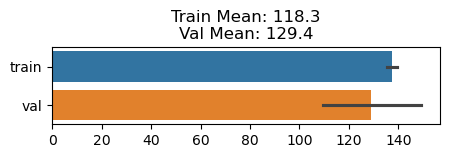

In [371]:
# error_train = 2 * pinball_loss(y_gt_train, y_pred_train[0], alpha=0.5)
# error_val = 2 * pinball_loss(y_gt_val, y_pred_val[0], alpha=0.5)


# quantiles = [0.5]
quantiles = [0.1, 0.5, 0.9]

error_train = 2 * np.stack([pinball_loss(y_gt_train, y_pred_train[i], alpha=q) for i, q in enumerate(quantiles)], axis=1).mean(axis=1)
# error_val = 2 * np.stack([pinball_loss(y_gt_val, y_pred_val[i], alpha=q) for i, q in enumerate(quantiles)], axis=1).mean(axis=1)
error_val = 2 * np.stack(
        [pinball_loss(y_gt_val, y_pred, alpha=q) for y_pred, q in zip(y_pred_val, [0.1, 0.5, 0.9])], axis=1
    ).mean(axis=1)

train_lengths = np.cumsum([0] + list(map(len, logs["train_index"])))
val_lengths = np.cumsum([0] + list(map(len, logs["val_index"])))


error_train_folds = np.array(
    [
        np.average(error_train[train_index[l:r]], weights=fy_weight_train[train_index[l:r]])
        for l, r in zip(train_lengths[:-1], train_lengths[1:])
    ]
)
error_val_folds = np.array(
    [
        np.average(error_val[val_index[l:r]], weights=fy_weight_val[val_index[l:r]])
        for l, r in zip(val_lengths[:-1], val_lengths[1:])
    ]
)

plt.figure(figsize=(5, 1))
sns.barplot(pd.DataFrame({"train": error_train_folds, "val": error_val_folds}), orient="h")
plt.title(
    # f"Results\n"
    f"Train Mean: {np.average(error_train, weights=fy_weight_train):.1f}\n"
    f"Val Mean: {np.average(error_val, weights=fy_weight_val):.1f}"
);

In [412]:
# from core.train import Ensemble
from core import recipes

quantiles = [0.1, 0.5, 0.9]

# model = Ensemble(
#         logs["models"],
#         logs["data_processor"],
#         # weights=[1] * len(logs["models"]),
#         weights=1 / error_val_folds,
#         # feature_columns=logs["models"][0].feature_name_,
#         feature_columns = None
# )
model = logs_n["model"]

X_pred_val2 = model.predict(X_test)
y_pred_val2 = X_pred_val2
val_index2 = np.arange(len(y_pred_val2[0]))
# y_gt_val = y_test.to_numpy()[val_index]
y_gt_val2 = y_test.to_numpy()
fy_weight_val = np.full(len(val_index2), 1)


error_train = 2 * np.stack([pinball_loss(y_gt_train, y_pred_train[i], alpha=q) for i, q in enumerate(quantiles)], axis=1).mean(axis=1)
error_val = 2 * np.stack([pinball_loss(y_gt_val2, y_pred_val2[i], alpha=q) for i, q in enumerate(quantiles)], axis=1).mean(axis=1)
error_val.mean(), np.average(error_train, weights=fy_weight_train)

(121.47562211771317, 118.26868593649745)

In [40]:
import plotly.express as px

m = models[0]

if REAL_TEST:
    X_test_, _, _ = data_processor.preprocess_transform(X_test, y_test, weight_val, mode="val")
    y_pred = m.predict(X_test_)
    y_pred_ = data_processor.postprocess_transform(X_test_, y_pred)
    df_viz = dataset[is_test].copy()
    df_viz["target"] = y_test
    df_viz["pred"] = y_pred_
else:
    fold_index = 1
    df_viz = dataset.loc[logs["val_index"][fold_index]].copy()
    df_viz["target"] = df_viz["volume"]
    df_viz["pred"] = logs["val_pred"][fold_index][0]

# df_viz = df_viz[df_viz.site_id.isin(cali_sites)]

print(2 * pinball_loss(df_viz["target"], df_viz["pred"], alpha=0.5).mean())
px.line(df_viz, x="forecast_year", y=["target", "pred"], color="site_id")


168.67324325655596


(array([ 49., 156., 333., 344., 158.,  61.,  10.,   7.,   9.,   4.]),
 array([0.03250123, 0.33454195, 0.63658268, 0.9386234 , 1.24066412,
        1.54270485, 1.84474557, 2.14678629, 2.44882702, 2.75086774,
        3.05290846]),
 <BarContainer object of 10 artists>)

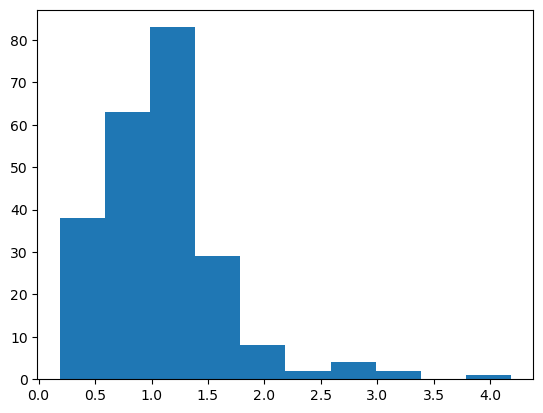

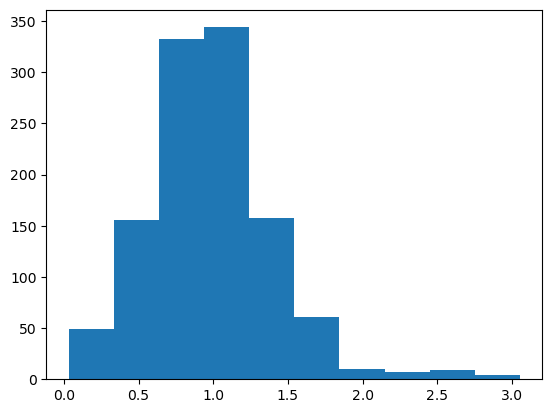

In [1172]:
plt.figure(0)
plt.hist(y_val)
plt.figure(1)
plt.hist(y_train)

In [1173]:
# masked = ~X.index.isin(X.iloc[train_index].index)
# dataset[masked]
# y[masked]

15.058715715362553

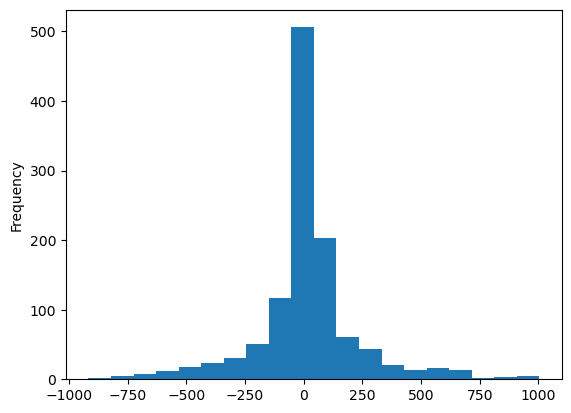

In [1174]:
diff = y_gt_val - y_pred_val[0]
# diff = y_gt_train - y_pred_train
pd.Series(diff).plot.hist(bins=20)
diff.mean()

In [1175]:
# X_data = dataset.loc[val_loc, ~dataset.columns.duplicated(keep="first")].copy()
df_viz["diff"] = df_viz["target"] - df_viz["pred"]
df_viz["error"] = np.abs(df_viz["diff"])
df_viz["error_normal"] = df_viz["error"] / df_viz["basins_area"]

In [1176]:
df_viz.groupby("site_id")["error"].mean().sort_values(ascending=False)

site_id
libby_reservoir_inflow            422.943804
snake_r_nr_heise                  389.342626
boise_r_nr_boise                  327.036535
missouri_r_at_toston              325.081917
yampa_r_nr_maybell                231.053661
owyhee_r_bl_owyhee_dam            216.924305
boysen_reservoir_inflow           199.061895
hungry_horse_reservoir_inflow     185.962075
fontenelle_reservoir_inflow       145.594913
skagit_ross_reservoir             107.487427
detroit_lake_inflow               103.204999
pueblo_reservoir_inflow            90.632583
animas_r_at_durango                66.367022
stehekin_r_at_stehekin             59.564865
green_r_bl_howard_a_hanson_dam     55.129136
colville_r_at_kettle_falls         51.022059
virgin_r_at_virtin                 41.977619
sweetwater_r_nr_alcova             22.030334
weber_r_nr_oakley                  18.094324
pecos_r_nr_pecos                   16.920039
dillon_reservoir_inflow            16.138236
ruedi_reservoir_inflow             12.944504
ta

In [1016]:
df_viz.groupby("site_id")["error_normal"].mean().sort_values(ascending=False)

site_id
stehekin_r_at_stehekin            0.231364
hungry_horse_reservoir_inflow     0.200742
detroit_lake_inflow               0.182981
skagit_ross_reservoir             0.175299
green_r_bl_howard_a_hanson_dam    0.173747
weber_r_nr_oakley                 0.086099
animas_r_at_durango               0.064243
libby_reservoir_inflow            0.057553
ruedi_reservoir_inflow            0.057292
boise_r_nr_boise                  0.046403
yampa_r_nr_maybell                0.046141
snake_r_nr_heise                  0.037705
pecos_r_nr_pecos                  0.036433
taylor_park_reservoir_inflow      0.036218
dillon_reservoir_inflow           0.035275
virgin_r_at_virtin                0.029518
colville_r_at_kettle_falls        0.026893
fontenelle_reservoir_inflow       0.024387
boysen_reservoir_inflow           0.019060
pueblo_reservoir_inflow           0.014375
owyhee_r_bl_owyhee_dam            0.013716
missouri_r_at_toston              0.013330
sweetwater_r_nr_alcova            0.008246
Nam

In [527]:
df_viz.groupby("site_id")["diff"].mean().sort_values(ascending=False)

site_id
american_river_folsom_lake                138.275015
merced_river_yosemite_at_pohono_bridge     -6.421586
san_joaquin_river_millerton_reservoir     -25.008325
Name: diff, dtype: float64

In [615]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 100)

In [616]:
# px.line(
#     X_data[
#         X_data["site_id"].isin(["libby_reservoir_inflow", "snake_r_nr_heise", "snake_r_nr_heise"])
#     ].sort_values(["site_id", "forecast_year"], ascending=True),
#     x="forecast_year",
#     y="V",
#     color="site_id",
# )

In [617]:
import plotly.express as px

px.line(
    X_data[
        X_data["site_id"].isin(['american_river_folsom_lake',
                                'san_joaquin_river_millerton_reservoir',
                                'merced_river_yosemite_at_pohono_bridge'])
    ].sort_values(["site_id", "forecast_year"], ascending=True),
    x="forecast_year",
    y=["pred", "volume"],
    color="site_id",
)

In [618]:
import plotly.express as px

px.line(
    X_data[
        X_data["site_id"].isin(["libby_reservoir_inflow", "snake_r_nr_heise", "owyhee_r_bl_owyhee_dam"])
    ].sort_values(["site_id", "forecast_year"], ascending=True),
    x="forecast_year",
    y=["pred", "volume"],
    color="site_id",
)

In [619]:
X_data[X_data["site_id"].isin(["libby_reservoir_inflow", "snake_r_nr_heise", "snake_r_nr_heise"])].sort_values("date", ascending=False)

,site_id,forecast_year,volume,volume_1,volume_10,volume_11,volume_12,season_start_month,season_end_month,elevation,...,TOTAL,ANOM,year,month,pdo_index,soi,pna_index,error,diff,pred
190,snake_r_nr_heise,2022,2389.842,149.641,204.865,170.421,158.188,4,7,5015.0,...,25.76,-0.92,2021,12,-2.71,1.5,-2.56,325.984875,-325.984875,2715.826875
624,libby_reservoir_inflow,2022,6230.893,253.247,293.275,469.521,578.023,4,7,2100.0,...,25.76,-0.92,2021,12,-2.71,1.5,-2.56,62.140614,-62.140614,6293.033614
623,libby_reservoir_inflow,2020,5799.534,178.109,303.837,208.181,223.556,4,7,2100.0,...,25.40,-1.27,2019,12,0.00,-0.6,0.18,898.228782,898.228782,4901.305218
189,snake_r_nr_heise,2020,3430.482,187.452,247.894,191.463,186.380,4,7,5015.0,...,25.40,-1.27,2019,12,0.00,-0.6,0.18,675.257694,675.257694,2755.224306
188,snake_r_nr_heise,2018,4257.072,224.620,297.101,294.082,241.901,4,7,5015.0,...,27.57,0.90,2017,12,-0.02,-0.1,0.89,702.647875,702.647875,3554.424125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,libby_reservoir_inflow,1969,7363.000,196.000,410.000,328.000,219.000,4,7,2100.0,...,27.14,0.81,1968,12,-0.29,0.2,-1.44,1638.820688,1638.820688,5724.179312
582,libby_reservoir_inflow,1971,6939.000,172.000,280.000,201.000,176.000,4,7,2100.0,...,25.46,-0.96,1970,12,-0.91,1.9,-0.79,629.982226,629.982226,6309.017774
583,libby_reservoir_inflow,1972,7992.363,154.314,292.760,237.025,170.579,4,7,2100.0,...,28.51,2.09,1971,12,-1.77,0.3,-1.46,1906.285232,1906.285232,6086.077768
588,libby_reservoir_inflow,1977,3027.357,166.646,348.041,247.754,208.992,4,7,2100.0,...,27.27,0.81,1976,12,1.20,-0.3,0.51,146.634211,146.634211,2880.722789


# Feature Imp

In [1381]:
catboost_model = models[0]

In [1382]:
feat_imp = catboost_model.get_feature_importance(
            type=cb.EFstrType.PredictionValuesChange,
            data=val_pool
        )

pd.DataFrame(
        feat_imp[None, :],
        columns=X.columns
) / feat_imp[0]

,ANOM_autocorr,ANOM_roll_max5,ANOM_roll_mean5,ANOM_roll_min5,NINO1+2,NINO3,NINO3 ANOM,NINO3.4,NINO3.4 ANOM,NINO4,NINO4 ANOM,PREC_DAILY,WTEQ_DAILY,basins_area,cos_yr2_1,cos_yr3_1,distance_station,distance_station_RAIN,distance_station_SNOW WC,elevation,elevation_station,latitude,latitude_station,latitude_station_RAIN,latitude_station_SNOW WC,longitude,longitude_station,longitude_station_RAIN,longitude_station_SNOW WC,month,pdo_index,pdo_index_roll_mean5,pdo_index_roll_std7,pna_index,pna_index_autocorr,sin_yr2_1,sin_yr3_1,site_id,soi_roll_mean5,stations_count,value_RAIN,value_SNOW WC,volume_ewm_mean7,volume_roll_max5,volume_roll_mean5,volume_roll_min5,volume_roll_std7
0,1.0,0.43489,0.443009,0.841707,0.547134,0.217604,0.210242,0.351256,0.316704,0.326971,0.175807,0.973493,3.278254,0.904201,0.070981,0.967486,0.625189,0.0,0.0,0.683776,0.754677,1.231481,0.899514,0.0,0.0,0.935676,1.158579,0.0,0.0,0.0,0.501012,0.541693,0.882737,0.666279,0.373006,0.19402,0.449161,0.676253,0.282772,0.580266,0.0,0.0,1.171619,1.115709,0.507867,1.054829,0.762889


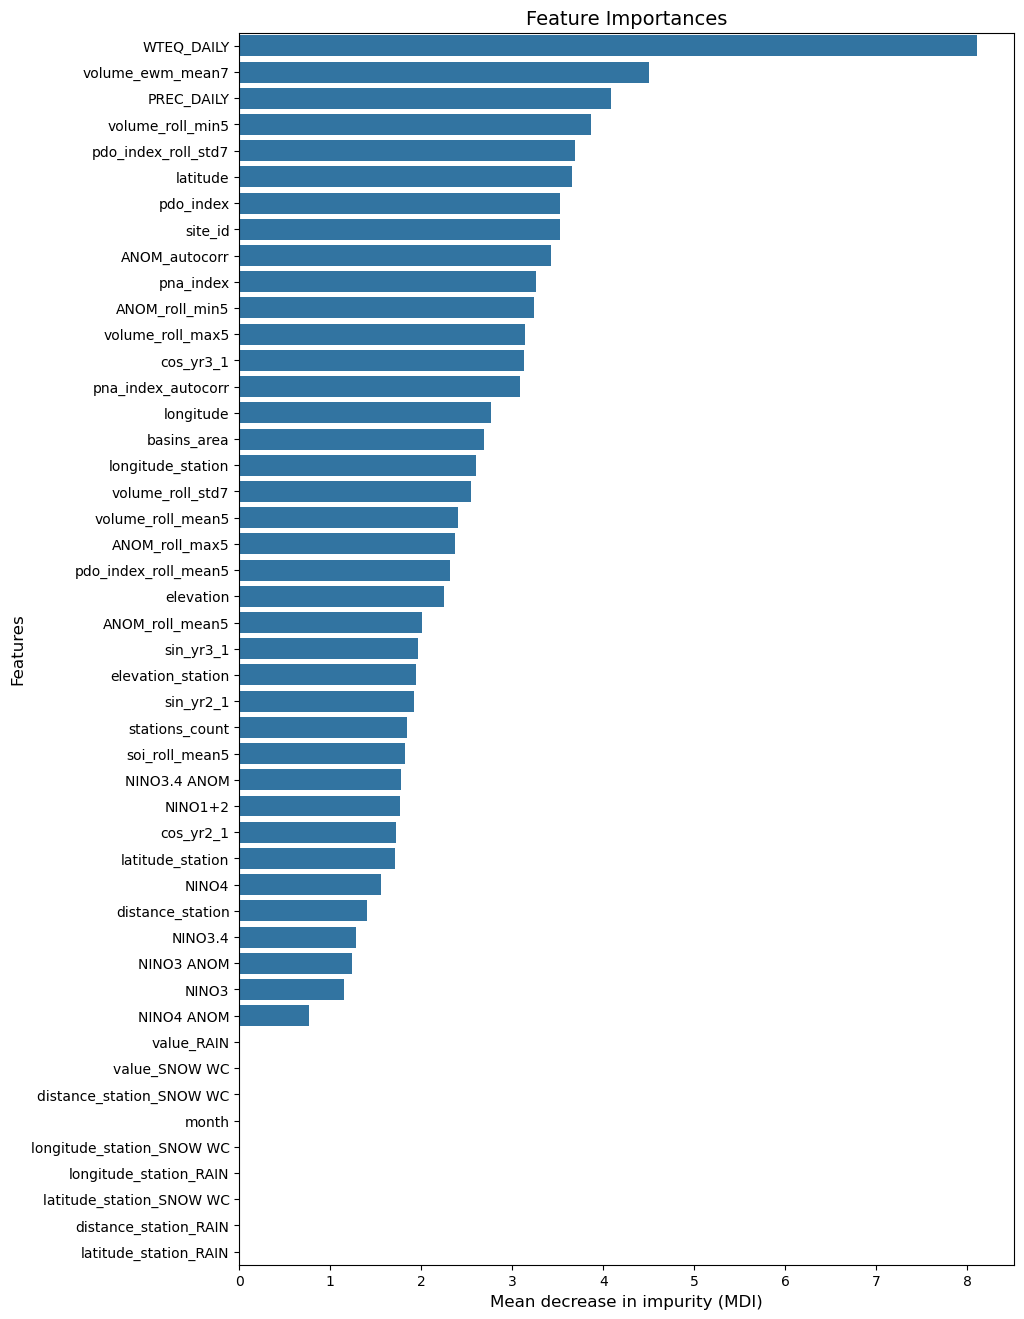

In [1383]:
from core.utils import plot_feature_importance

features = X.columns
importance = catboost_model.get_feature_importance()
plot_feature_importance(features, importance);

In [255]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_val)

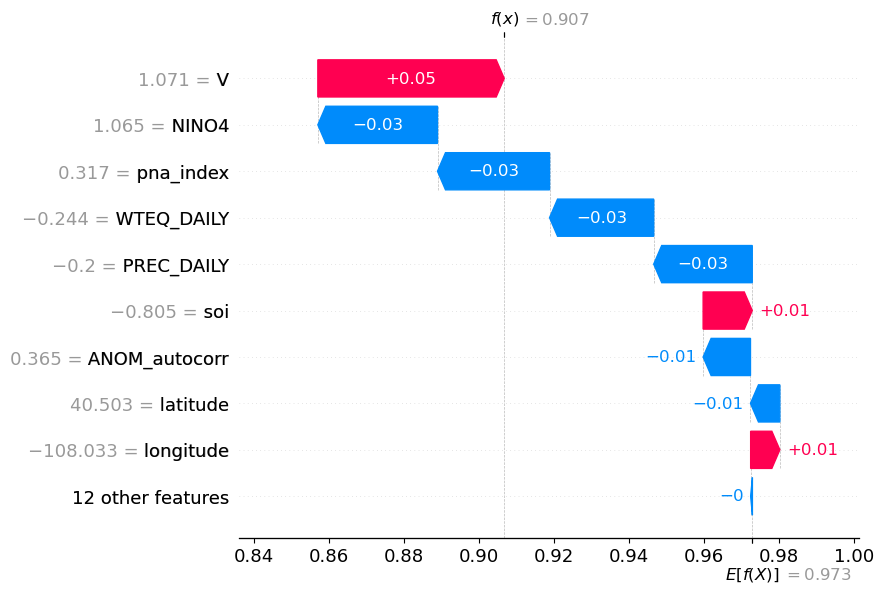

In [257]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[100])

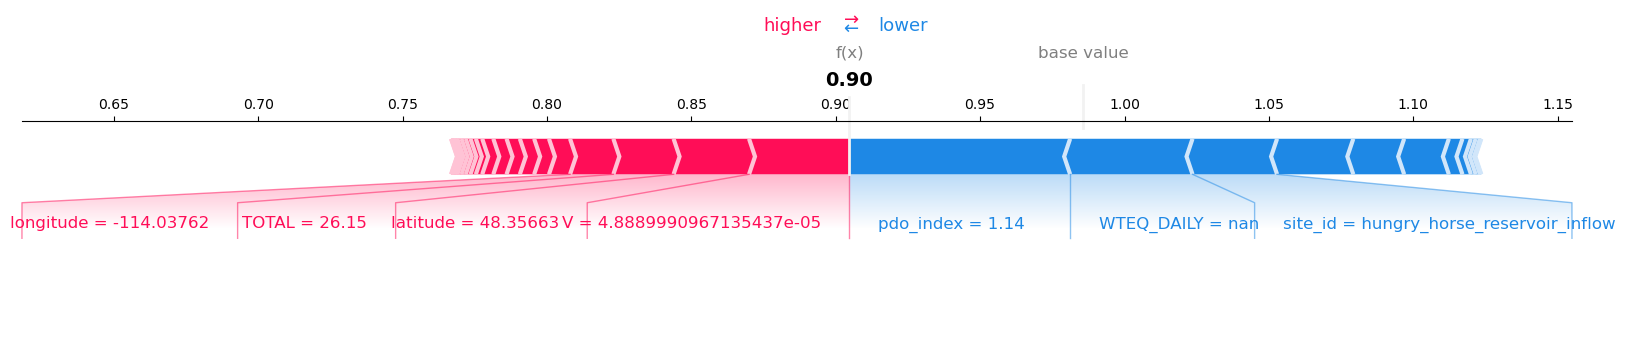

In [151]:
# shap.initjs()
shap.plots.force(shap_values[0], matplotlib=True)

In [48]:
shap.plots.force(shap_values, matplotlib=True)

NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!

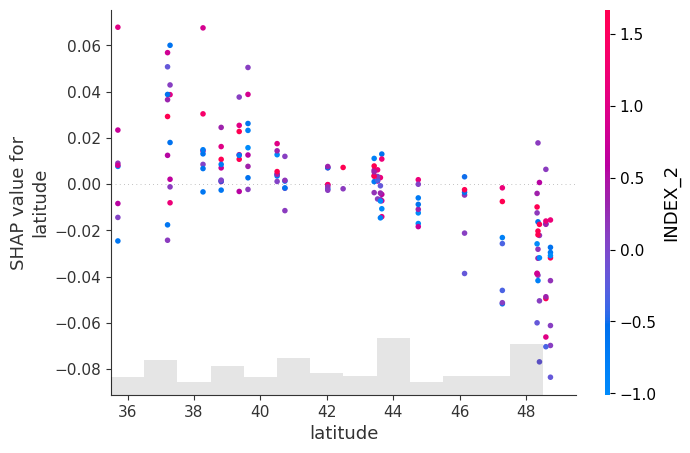

In [49]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "latitude"], color=shap_values)

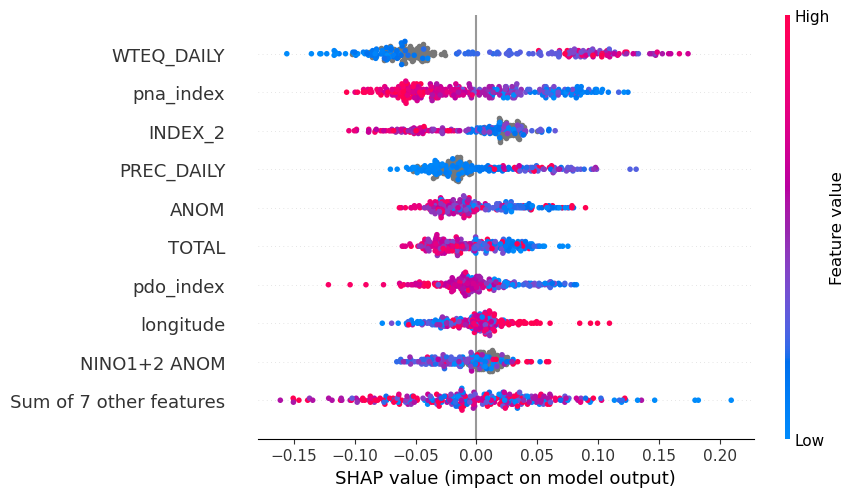

In [50]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

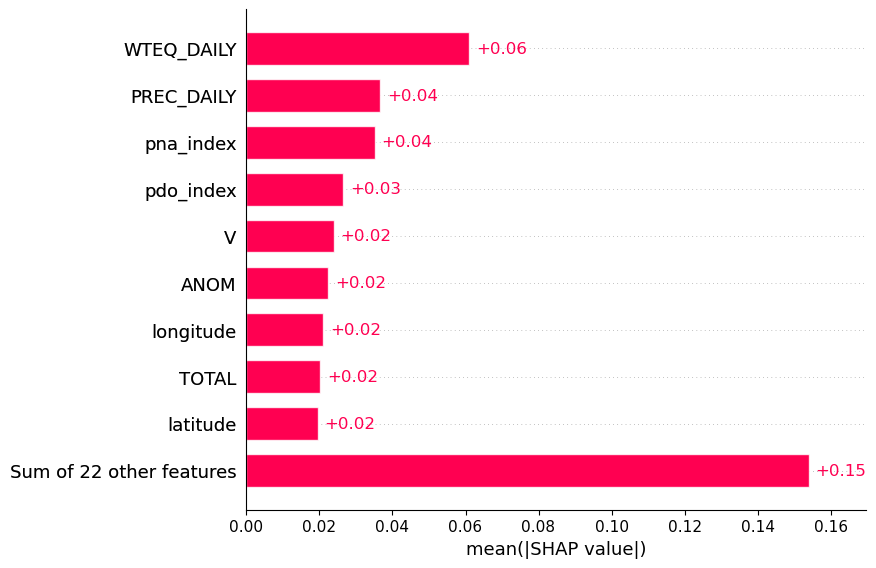

In [154]:
shap.plots.bar(shap_values)

In [155]:
catboost_model.base_models

AttributeError: 'CatBoostRegressor' object has no attribute 'base_models'

In [158]:
# shap.TreeExplainer(catboost_model).shap_interaction_values(X)

In [665]:
import cdsapi
c = cdsapi.Client(
    url="https://cds.climate.copernicus.eu/api/v2",
    key="275276:19c84c47-6d85-49ef-9fdd-34b9268e9d6e"
)
# Define your data request parameters
request_params = {
    'product_type': 'monthly_mean',  # Change this as needed
    'format': 'grib',               # Data format (e.g., 'grib', 'netcdf')
    'variable': '2m_temperature',   # Change this to the variable you want
    'year': '2020',                 # Specify the year
    'month': ['01', '02', '03'],    # Specify months
    'day': ['01', '15', '31'],      # Specify days
    'time': '12:00',                # Specify time (for subdaily data)
    'leadtime_hour': ['24', '48', '72'],  # Lead time hours
}

# Download the data
c.retrieve(
    'seasonal-original-single-levels',  # This is the dataset identifier
    request_params,
    'downloaded_data.grib'              # Output filename
)

2023-12-16 00:31:06,785 INFO Welcome to the CDS
2023-12-16 00:31:06,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2023-12-16 00:31:07,002 INFO Request is queued
2023-12-16 00:31:08,185 INFO Request is running
2023-12-16 00:31:57,718 INFO Request is failed
2023-12-16 00:31:57,732 ERROR Message: Killed by system admin due to internal issue
2023-12-16 00:31:57,733 ERROR Reason:  Killed by system admin due to internal issue


Exception: Killed by system admin due to internal issue. Killed by system admin due to internal issue.

# Feature Selection

In [89]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# X, y = make_regression(n_samples=1000, n_features=100, n_informative=20, random_state=0)
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)
# feature_names = ['F{}'.format(i) for i in range(train_X.shape[1])]
# train_pool = Pool(train_X, train_y, feature_names=feature_names)
# test_pool = Pool(test_X, test_y, feature_names=feature_names)


model = CatBoostRegressor(**{k:v for k,v in default_model_params.items() if k != "feature_weights"})
summary = model.select_features(
    train_pool,
    eval_set=val_pool,
    features_for_select=X_train.columns,
    num_features_to_select=15,
    steps=20,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

summary["eliminated_features_names"]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

['pdo_index_autocorr',
 'pna_index_roll_mean5',
 'INDEX_2',
 'pna_index_roll_max5',
 'pna_index_ewm_mean7',
 'SNWD_DAILY',
 'soi_roll_max5',
 'soi',
 'NINO1+2 ANOM',
 'ANOM',
 'ANOM_roll_std7',
 'soi_autocorr',
 'NINO4',
 'ANOM_roll_max5',
 'TOTAL',
 'soi_roll_std7',
 'ANOM_autocorr',
 'soi_ewm_mean7',
 'pdo_index_roll_mean5',
 'pdo_index_roll_max5',
 'pdo_index',
 'ANOM_ewm_mean7',
 'pdo_index_roll_min5',
 'pdo_index_ewm_mean7',
 'pna_index_roll_std7',
 'pna_index_autocorr',
 'ANOM_roll_min5',
 'soi_roll_min5',
 'pna_index_roll_min5',
 'elevation',
 'volume_autocorr',
 'month']

# Pile

In [156]:
"""
Experiments
1: MVP CV-5 train/val loss: 210 - 249
2: MVP + site metadata: 204 - 234
3: Removing volume scale from #2: 329 - 351
4: Depth + LR tuning: didn't improve

"""

"\nExperiments\n1: MVP CV-5 train/val loss: 210 - 249\n2: MVP + site metadata: 204 - 234\n3: Removing volume scale from #2: 329 - 351\n4: Depth + LR tuning: didn't improve\n\n"

In [362]:
df_targets.site_id.unique()

array(['animas_r_at_durango', 'boise_r_nr_boise',
       'boysen_reservoir_inflow', 'colville_r_at_kettle_falls',
       'detroit_lake_inflow', 'dillon_reservoir_inflow',
       'fontenelle_reservoir_inflow', 'green_r_bl_howard_a_hanson_dam',
       'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow',
       'missouri_r_at_toston', 'owyhee_r_bl_owyhee_dam',
       'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',
       'ruedi_reservoir_inflow', 'skagit_ross_reservoir',
       'snake_r_nr_heise', 'stehekin_r_at_stehekin',
       'sweetwater_r_nr_alcova', 'taylor_park_reservoir_inflow',
       'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell'],
      dtype=object)

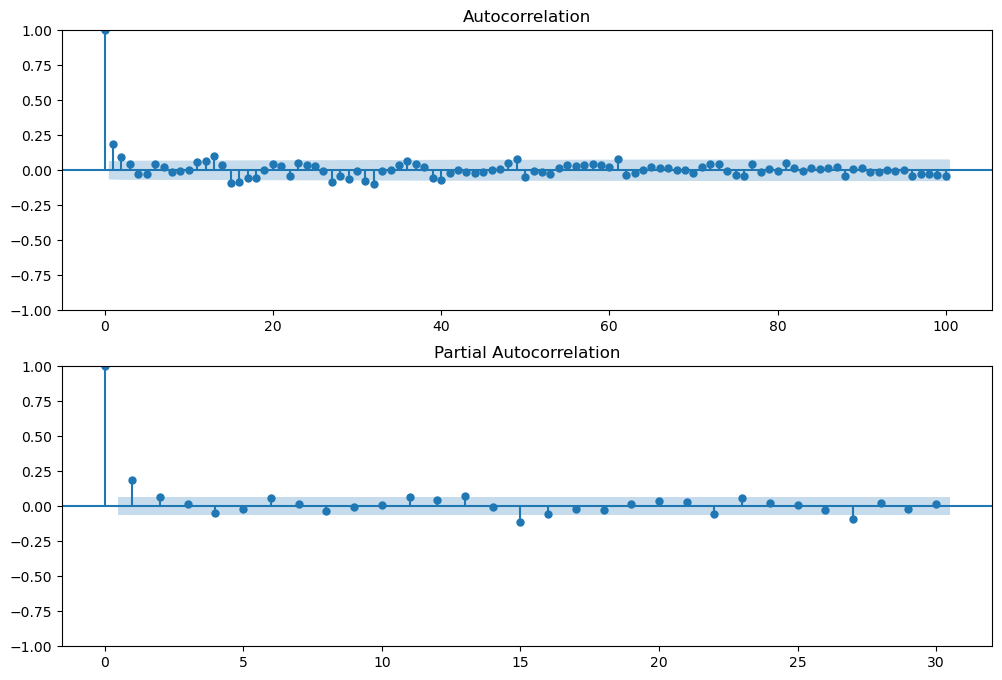

In [458]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Visualizations
lag_acf = 5
lag_pacf = 10
height = 4
width = 12

sample = teleconn_data["PNA"]

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['pna_index'].dropna(), lags=100, ax=ax[0]);
plot_pacf(sample['pna_index'].dropna(), ax=ax[1], method='ols');

In [227]:
df_oct_dec = df_monthly.groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].isin([10, 11, 12])]
    .sort_values("month")
    .set_index("month")["volume"]
)
df_oct_dec = pd.pivot_table(
    df_oct_dec.reset_index(), index=["site_id", "forecast_year"], columns="month"
)
df_oct_dec.columns = df_oct_dec.columns.map(lambda x: "_".join(map(str, x)))
df_oct_dec = df_oct_dec.reset_index()


    # .merge(
    #     df_oct_dec,
    #     on=["site_id", "forecast_year"],
    #     how="inner",
    # )    
# )
# dataset["issue_date"] = dataset["forecast_year"].apply(lambda y: get_issue_date(y))
# dataset

In [ ]:
import plotly.express as px

gg = df_train_monthly.merge(metadata, on="site_id").groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].between(df["season_start_month"], df["season_end_month"])]["volume"].sum()
).reset_index(name="volume_est").merge(df_train_targets.rename(columns={"year": "forecast_year"}), on=["site_id", "forecast_year"])


gg["r"] = gg["volume_est"] / gg["volume"]
gg2 = gg.merge(gg.groupby("site_id")["r"].median().reset_index(name="r_med"), on="site_id")
gg2["volume_est_2"] = gg2["volume_est"] / gg2["r_med"]
gg2["r2"] = gg2["volume_est_2"] / gg2["volume"]

px.line(
    df_train_targets.sort_values(["site_id", "year"], ascending=True),
    x="year",
    y=["volume"],
    color="site_id",
)

px.line(
    gg2.sort_values(["site_id", "forecast_year"], ascending=True),
    x="forecast_year",
    y=["r2"],
    color="site_id",
)

metadata

gg2 = gg.merge(gg.groupby("site_id").apply(lambda gg: (gg["volume_est"] / gg["volume"]).reset_index(name="r")), on="site_id")
gg2.groupby("site_id")["r"].describe()
gg.groupby("site_id").apply(lambda gg: (gg["volume_est"] / gg["volume"]).median())

In [392]:
import plotly.express as px

px.line(
    dataset.sort_values(["site_id", "year"], ascending=True),
    x="year",
    y=["SNWD_DAILY"],
    color="site_id",
)

In [33]:
import plotly.express as px

px.line(
    dataset.query("issue_date.dt.month == 1")
    # .merge(df_train_targets_v2[["site_id", "forecast_year"]], on=["site_id", "forecast_year"])
    .sort_values(["site_id", "year"], ascending=True)
    ,
    x="year",
    y=["volume"],
    color="site_id",
)

In [436]:
import plotly.express as px

px.line(
    df_targets.sort_values(["site_id", "year"], ascending=True),
    x="year",
    y=["volume"],
    color="site_id",
)

In [ ]:
# df_oct_dec = df_train_monthly.groupby(["site_id", "forecast_year"]).apply(
#     lambda df: df[df["month"].isin([10, 11, 12])]
#     .sort_values("month")
#     .set_index("month")["volume"]
# )
# df_oct_dec = pd.pivot_table(
#     df_oct_dec.reset_index(), index=["site_id", "forecast_year"], columns="month"
# )
# df_oct_dec.columns = df_oct_dec.columns.map(lambda x: "_".join(map(str, x)))
# df_oct_dec = df_oct_dec.reset_index()

# dataset = (
#     df_train_targets
#     .rename(columns={"year": "forecast_year"})
#     .dropna() # Cali sites are dropped
#     .merge(ALL_ISSUE_DATES[ALL_ISSUE_DATES.dt.month == 1], left_on="forecast_year", right_on=ALL_ISSUE_DATES[ALL_ISSUE_DATES.dt.month == 1].dt.year)
#     .merge(metadata, on="site_id", suffixes=("", "_md"))
#     .merge(
#         df_oct_dec,
#         on=["site_id", "forecast_year"],
#         how="inner",
#     )    
# )
# dataset

In [ ]:
 # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.1'),
        # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.5'),
        # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.9'),

        # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.1), eval_metric=RmseQuantilieMetric(quantile=0.1)),
        # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.5), eval_metric=RmseQuantilieMetric(quantile=0.5)),
        # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.9), eval_metric=RmseQuantilieMetric(quantile=0.9)),

In [54]:
# X[["volume_10", "volume_11", "volume_12"]] = X[["volume_10", "volume_11", "volume_12"]] / X["basins_area"].values[:, None]
# X["V"] = dataset[["volume_10", "volume_11", "volume_12"]].mean(axis=1)  / (X["basins_area"].values ** 2)


# X = X.drop(columns=["volume_10", "volume_11", "volume_12"])
# X = X.reset_index(drop=True).dropna(subset="V").reset_index(drop=True)
# site_codes = site_codes.iloc[X.index].reset_index(drop=True)
# y = y.iloc[X.index].reset_index(drop=True)
# weight = weight[X.index]
